<a href="https://colab.research.google.com/github/dbeniteze/clima_autoencoder/blob/master/clima_convlstm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip3 install keras==2.3.1

!apt-get install libgeos-3.5.0
!apt-get install libgeos-dev
!pip install https://github.com/matplotlib/basemap/archive/master.zip     #basemap

!pip install pyproj==1.9.6   #posible arreglo



%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

     |████████████████████████████████| 378kB 8.8MB/s 
  Found existing installation: Keras 2.2.5
    Uninstalling Keras-2.2.5:
      Successfully uninstalled Keras-2.2.5
Reading package lists... Done
Building dependency tree       
Reading state information... Done
E: Unable to locate package libgeos-3.5.0
E: Couldn't find any package by glob 'libgeos-3.5.0'
E: Couldn't find any package by regex 'libgeos-3.5.0'
Reading package lists... Done
Building dependency tree       
Reading state information... Done
Suggested packages:
  libgdal-doc
The following NEW packages will be installed:
  libgeos-dev
0 upgraded, 1 newly installed, 0 to remove and 25 not upgraded.
Need to get 73.1 kB of archives.
After this operation, 486 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libgeos-dev amd64 3.6.2-1build2 [73.1 kB]
Fetched 73.1 kB in 0s (1,428 kB/s)
Selecting previously unselected package libgeos-dev.
(Reading database ... 145118 files and

     |████████████████████████████████| 2.8MB 8.9MB/s 
  Created wheel for pyproj: filename=pyproj-1.9.6-cp36-cp36m-linux_x86_64.whl size=3702064 sha256=63881f394cfa503dee3071d5a4354f9daa40e0c804ef865f457f7d46972ee034
  Stored in directory: /root/.cache/pip/wheels/02/cd/b1/a2d6430f74c7a778a43d62f78bec109ca69c732dc9b929142a
Successfully built pyproj
  Found existing installation: pyproj 2.5.0
    Uninstalling pyproj-2.5.0:
      Successfully uninstalled pyproj-2.5.0
TensorFlow 2.x selected.
Found GPU at: /device:GPU:0


In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# Larger CNN for the MNIST Dataset
from keras import backend as K
from keras.datasets import cifar10
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout, Reshape
from keras.layers import Flatten, BatchNormalization
from keras.layers import LeakyReLU
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.utils import np_utils
from matplotlib import pyplot as plt
import numpy as np
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose, AveragePooling2D
from keras.models import Model
from keras.optimizers import Adam
from keras import backend as K

import os




X_train = np.load("drive/My Drive/temperaturas/temp_tropp.npy", allow_pickle=True)




Using TensorFlow backend.


In [0]:
from keras.layers import  AveragePooling2D
X_train = X_train.reshape((X_train.shape[0], 1, 73, 144, 1)).astype('float32')

1#rango de temperaturas
minimo = np.min(X_train)
maximo = np.max(X_train)

X_train = (X_train - minimo) / (maximo - minimo)


In [0]:
from keras.layers import Input, LSTM, RepeatVector, ConvLSTM2D
from keras.models import Model


#autoencoder con Conv2DTranspose
input_img = Input(shape=(None, 73, 144, 1))  # adapt this if using `channels_first` image data format
LF = (4,5)
x = ConvLSTM2D(32, kernel_size=LF, strides=2, padding="same", activation='elu', return_sequences=True)(input_img)
x = BatchNormalization()(x)


x = ConvLSTM2D(8, kernel_size=LF, strides=2, padding="same", activation='elu', return_sequences=True)(x)
x = BatchNormalization()(x)

encoded = Reshape((7, 7, 8))(x)

x = Conv2DTranspose(8, kernel_size=LF, strides=2, padding="same", activation='elu')(encoded)
x = BatchNormalization()(x)
x = Conv2DTranspose(1, kernel_size=LF,  strides=2,padding="same", activation='elu')(x)
decoded = Reshape((1, 28, 28, 1))(x)

autoencoder = Model(input_img, decoded)
autoencoder.summary()


In [0]:
from keras.layers import Input, LSTM, RepeatVector, ConvLSTM2D
from keras.models import Model
from keras.layers import PReLU, Add

input_img = Input(shape=(None, 73, 144, 1))
LF = (4,5)    #reduccion input 73 a num par
x = ConvLSTM2D(64, kernel_size=LF,  activation='elu', return_sequences=True)(input_img)   #70 140 
#x = PReLU(alpha_initializer='zeros')(x)
x = BatchNormalization()(x)

x = ConvLSTM2D(32, kernel_size=LF,  activation='elu', return_sequences=True)(x) 
#x = PReLU(alpha_initializer='zeros')(x)        #67 136
x = BatchNormalization()(x)

x = ConvLSTM2D(32, kernel_size=LF, activation='elu', return_sequences=True)(x)  
#x = PReLU(alpha_initializer='zeros')(x)       #64 132
x = BatchNormalization()(x)

LF = (5,5)
x = ConvLSTM2D(16, kernel_size=LF, strides=2, padding= "same", activation='elu', return_sequences=True)(x) 
#x = PReLU(alpha_initializer='zeros')(x) #32, 66
x = BatchNormalization()(x)

x = ConvLSTM2D(16, kernel_size=LF, strides=2, padding= "same", activation='elu', return_sequences=True)(x)
#x = PReLU(alpha_initializer='zeros')(x)
x = BatchNormalization()(x)

x = ConvLSTM2D(8, kernel_size=LF, padding= "same", activation='elu', return_sequences=True)(x)
#x = PReLU(alpha_initializer='zeros')(x)
x = BatchNormalization()(x)


x = ConvLSTM2D(4, kernel_size=LF, padding= "same",  activation='elu', return_sequences=True)(x)

encoded = Reshape((16,33,4))(x)
###########

#encoded = Model(input_img, encoded)
#encoded.summary()

x = Conv2DTranspose(4, kernel_size=LF, activation='elu', padding= "same")(encoded)
#x = PReLU(alpha_initializer='zeros')(x)
x = BatchNormalization()(x)

x = Conv2DTranspose(8, kernel_size=LF, activation='elu', padding= "same")(x)
#x = PReLU(alpha_initializer='zeros')(x)
x = BatchNormalization()(x)

x = Conv2DTranspose(16, kernel_size=LF, strides=2, activation='elu', padding= "same")(x)
#x = PReLU(alpha_initializer='zeros')(x)
x = BatchNormalization()(x)

x = Conv2DTranspose(32, kernel_size=LF, strides=2, activation='elu', padding= "same")(x)
#x = PReLU(alpha_initializer='zeros')(x)
x = BatchNormalization()(x)

LF = (4,5)
x = Conv2DTranspose(32, activation='elu', kernel_size=LF)(x)
#x = PReLU(alpha_initializer='zeros')(x)
x = BatchNormalization()(x)

x = Conv2DTranspose(64, activation='elu', kernel_size=LF)(x)
#x = PReLU(alpha_initializer='zeros')(x)
x = BatchNormalization()(x)

x = Conv2DTranspose(1, kernel_size=LF, activation='sigmoid')(x)

decoded = Reshape((1, 73, 144, 1))(x)

autoencoder = Model(input_img, decoded)
autoencoder.summary()


Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, None, 73, 144, 1)  0         
_________________________________________________________________
conv_lst_m2d_8 (ConvLSTM2D)  (None, None, 70, 140, 64) 333056    
_________________________________________________________________
batch_normalization_13 (Batc (None, None, 70, 140, 64) 256       
_________________________________________________________________
conv_lst_m2d_9 (ConvLSTM2D)  (None, None, 67, 136, 32) 245888    
_________________________________________________________________
batch_normalization_14 (Batc (None, None, 67, 136, 32) 128       
_________________________________________________________________
conv_lst_m2d_10 (ConvLSTM2D) (None, None, 64, 132, 32) 163968    
_________________________________________________________________
batch_normalization_15 (Batc (None, None, 64, 132, 32) 128 

In [0]:
epoch = 10

def lr_schedule(epoch):
    lrate = 0.0001
    if epoch > 3:
        lrate = 0.00003
    if epoch > 7:
        lrate = 0.00001
    return lrate


def coeff_determination(y_true, y_pred):
    SS_res =  K.sum(K.square( y_true-y_pred ))
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) )
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

autoencoder.compile(optimizer=Adam(learning_rate=lr_schedule(epoch)),  loss="mse", metrics=[coeff_determination])

autoencoder.fit(X_train, X_train,
                epochs=epoch,
                batch_size=32,
                shuffle=True,
                validation_split=0.2)


Train on 21078 samples, validate on 5270 samples
Epoch 1/10
21078/21078 [==============================] - 559s 27ms/step - loss: 1.4357e-04 - coeff_determination: 0.9910 - val_loss: 1.6947e-04 - val_coeff_determination: 0.9901
Epoch 2/10
 9408/21078 [============>.................] - ETA: 4:45 - loss: 1.4337e-04 - coeff_determination: 0.9910

In [0]:
autoencoder.save("clima_convlstm.h5")

In [0]:
from keras.models import load_model

def coeff_determination(y_true, y_pred):
    SS_res =  K.sum(K.square( y_true-y_pred ))
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) )
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

autoencoder = load_model("clima_convlstm_ultimo.h5", custom_objects={'coeff_determination': coeff_determination})

In [0]:
decoded_imgs = autoencoder.predict(X_train)

In [0]:
#visualizacion de la decodificacion

X_train = X_train.reshape((X_train.shape[0], 73, 144, 1))
decoded_imgs = decoded_imgs.reshape((decoded_imgs.shape[0], 73, 144, 1))



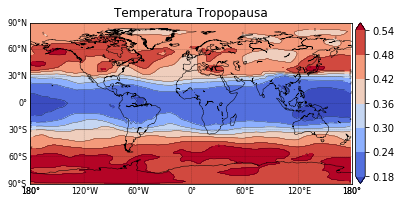

In [0]:
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap, shiftgrid
from numpy import float32



lat = np.arange(90,-92.5,-2.5)
lon = np.arange(0,360,2.5)

a = X_train[0].reshape(73, 144)

# make some plot 
#print('Ploting...')
#plt.figure() #setting the figure size

map = Basemap(projection='cyl',llcrnrlat=-90,urcrnrlat=90,\
            llcrnrlon=-180,urcrnrlon=180)      
#This like sets the lat lon of the plot. Projection cylinder. 

map.drawcoastlines(linewidth=.5)  #draws coastline 

parallels = np.arange(-90,91,30.) # make latitude lines ever 30 degrees from 30N-50N
meridians = np.arange(-180,180,60.) # make longitude lines every 60 degrees from 95W to 70W

#labelling the lat and lon dimesion

map.drawparallels(parallels,labels=[1,0,0,0],linewidth=0.2,fontsize=8)
map.drawmeridians(meridians,labels=[0,0,0,1],linewidth=0.2,fontsize=8)

a, lonout = shiftgrid(180, a, lon, start=False, cyclic=360.0)
lons,lats= np.meshgrid(lonout,lat) #2D lat lon to plot contours



x,y = map(lons,lats)


csf = map.contourf(x,y,a, extend='both',cmap='coolwarm') #filled contour
cb = map.colorbar(csf,"right", extend='both',size="3%", pad="1%")
cs = map.contour(x,y,a,colors='k',linewidths=0.3)


plt.clabel(cs, inline=True, fmt='%1.0f', fontsize=3, colors='k')
plt.title('Temperatura Tropopausa')
plt.show()

plt.close()




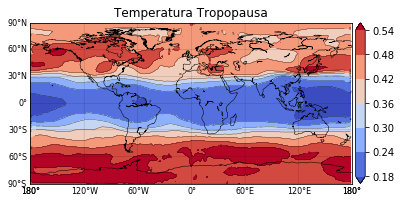

In [0]:
lat = np.arange(90,-92.5,-2.5)
lon = np.arange(0,360,2.5)


b = decoded_imgs[0].reshape(73, 144)

# make some plot 
#print('Ploting...')
#plt.figure() #setting the figure size

map = Basemap(projection='cyl',llcrnrlat=-90,urcrnrlat=90,\
            llcrnrlon=-180,urcrnrlon=180)      
#This like sets the lat lon of the plot. Projection cylinder. 

map.drawcoastlines(linewidth=.5)  #draws coastline 

parallels = np.arange(-90,91,30.) # make latitude lines ever 30 degrees from 30N-50N
meridians = np.arange(-180,180,60.) # make longitude lines every 60 degrees from 95W to 70W

#labelling the lat and lon dimesion

map.drawparallels(parallels,labels=[1,0,0,0],linewidth=0.2,fontsize=8)
map.drawmeridians(meridians,labels=[0,0,0,1],linewidth=0.2,fontsize=8)

b, lonout = shiftgrid(180, b, lon, start=False, cyclic=360.0)
lons,lats= np.meshgrid(lonout,lat) #2D lat lon to plot contours



x,y = map(lons,lats)


csf = map.contourf(x,y,b, extend='both',cmap='coolwarm') #filled contour
cb = map.colorbar(csf,"right", extend='both',size="3%", pad="1%")
cs = map.contour(x,y,b,colors='k',linewidths=0.3)


plt.clabel(cs, inline=True, fmt='%1.0f', fontsize=3, colors='k')
plt.title('Temperatura Tropopausa')
plt.show()